<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/two-dimensions/Two_dimensions_Kendama_change_Class_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### すること
辞書行列に変更 ←現在これに着手 \\
推測のプログラム作成 \\


---

### 終わったこと
2次元への修正 \\
稲邑教授の実験条件に似るように変更 \\
↑特に試行回数と難易度調整部分 \\
成功時と失敗時の皿の調整度調整方法を変更 \\
list型をndarayに統一して行列の計算を簡易化する(shapeが違うndarrayを結合する方法がわからない) \\
5回ずつぐらいで平均を取れるようにも改変する \\
グラフ描写の関数をもっと可変性のあるものにする。（例えば、欲しいグラフは似たようなものが多いから引数を変えるだけで目的のグラフを作れるようにする、グラフの初期化など \\
makeクラスで作成、showクラスで任意のものを表示かつ初期化 \\
xとyのユークリッド距離を使用した分散を求める \\


## わかったこと
おそらくαとβの関係性において、３種類の場合がありえる \\
1.   α=βの場合：均衡が取れているので一般的な難易度調整のパラメータで良さげな結果が取れている
2.   α>βの場合：成功した時の方が効果が大きいため、他の人よりもやる気があり分散が小さくなる傾向がありそう
3.   α<βの場合：失敗した時の方が効果が大きいため、他の人よりもやる気がなく分散が大きくなる傾向がありそう

### 調整の比率について
α<βの場合、α:β=1:2の場合、何度調整は簡易化:困難化=3:1だと良いくらい \\






# 実験においての注意点
実験データとシミュレーションにおいては \\
実データ半径0.1m = シミュレーション半径r=1 \\
が成り立つため、両方を比較で使用する場合は10倍のスケーリングが必要 \\
本来はすでに経験があるなどで、標準偏差の初期値は変わるだろうが今回は全員がニュートラルの状態からスタートしたと考えて√2からスタートとする。(こうすることでパラメータαとβの影響のみと考えられる) \\


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
import itertools

In [55]:
dispersion_xy = np.array(1)
print(dispersion_xy)
dispersion_xy = np.array([1])
print(dispersion_xy)

1
[1]


In [56]:
class Kendama():    #学習率、皿の移動割合、難易度調整の割合、難易度の初期値を格納
  def __init__(self, get_times): #get_timesはけん玉の総試行回数
    # self.alpha = alpha    #学習率
    # self.beta = beta    #学習率
    # self.a = a    #皿の移動割合
    # self.rt = rt    #難易度調整の割合
    # self.success_rate = success_rate #難易度調整を行う際の成功率の指標
    # self.fail_rate = fail_rate #難易度調整を行う際の失敗率の指標
    mu = np.array([0, 0])
    sigma = np.array([[1, 0], [0, 1]])
    # 2次元正規乱数をけん玉の総試行回数分生成(可能なら独立させて、データを持ち続けるか、リセットを任意にできるようにしたい)
    self.B = np.random.multivariate_normal(mu, sigma, size=get_times)  #けん玉の落下データを格納する配列（locは平均、scaleは標準偏差、sizeは導かれる値の数）つまり各試行時のけん玉の落下位置

  def Ajustment(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment, pattern): #難易度を調整した場合（半径を小さくするのみ）の結果を表す関数
    dispersion = np.array([[1**2, 1**2, 0]])    #被験者のやる気を表す分散を格納する配列
    dispersion_xy = np.array([1]) #xとyのユークリッド距離の分散
    p = np.array([[0,0]])       #皿のガウス分布の平均値を格納する配列
    # success_rate = 0.66 #難易度調整を行う際の成功率の指標
    # fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
    success = 0    #成功回数を表す変数
    trial = 0       #試行回数を表す変数
    x = np.array([])  #試行回数を格納
    R = np.array([])
    srate = np.array([0])
    success = 0
    Abs_degree_failure = np.array([0])
    R = np.append(R, r)
    for i in range(len(self.B)):
      trial += 1
      x = np.append(x, i)
      R = np.append(R, r)
      mu = np.array([p[i][0], p[i][1]])   #平均
      sigma = np.array([[dispersion[i][0], dispersion[i][2]],[dispersion[i][2], dispersion[i][1]]])   #共分散行列
      D = np.random.multivariate_normal(mu, sigma, size=1) #皿の位置を表す変数
      D = D[0] #1次元の配列ができているので取り出す作業
      abs_degree_failure = abs(np.sqrt((self.B[i][0] - D[0])**2+(self.B[i][1] - D[1])**2)) #皿の中心と落下位置の差（絶対値）
      # if abs_degree_failure <= 0:
      #    abs_degree_failure = 0
      Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure)
      if (self.B[i][0]-D[0])**2+(self.B[i][1]-D[1])**2 <= r**2:     #成功した時の分散の変化
        p = np.append(p, [D], axis=0)
        dispersion = np.append(dispersion, [dispersion[i] / alpha], axis=0)
        dispersion_xy = np.append(dispersion_xy, (dispersion[i][0] / alpha)*2)
        success += 1
        if ajustment:  #Trueなら調整ありなため、半径に対して調整を行う

          r = r / ganma #成功した時の難易度調整

          #  if r < 0.1:    #半径が０.1未満にならないようにするための処置
          #    r = 0.1
      else:       #失敗した時の分散の変化
        if ajustment:
          r = r * ganma
          #r = (r + max(0,(abs_degree_failure-r))) * ganma   #失敗した時の難易度調整※いらない場合はコメントアウトさせる
          #  if r > 3.1:    #半径が０.1未満にならないようにするための処置
          #    r = 3.1
        p = np.append(p, [self.B[i]], axis=0)
        dispersion = np.append(dispersion, [dispersion[i] * beta], axis=0)
        dispersion_xy = np.append(dispersion_xy, (dispersion[i][0] * beta)*2)
      #srateのコードは平均を取れるようにするため、変更が必要
      if pattern == "default":
        srate = np.append(srate, (success/(i+1))*100)
      else:
        srate = np.append(srate, success*100)
        success = 0
    x = np.append(x, len(self.B))
    #以下のコードは最初に入れた初期値を削除するコード
    x = np.delete(x, 0)
    p = np.delete(p, 0, axis=0)
    dispersion = np.delete(dispersion, 0, axis=0)
    dispersion_xy = np.delete(dispersion_xy, 0)
    R = np.delete(R, 0)
    Abs_degree_failure = np.delete(Abs_degree_failure, 0)
    srate = np.delete(srate, 0)
    return x,p,dispersion_xy,R,Abs_degree_failure,srate

    #指定した幅での平均を使った解析
  def divided_analyze(self, x, p, dispersion_xy, R, Abs_degree_failure, srate, pattern, width):
    #新しい配列に1つずつずらした5つの値の平均を入れる
    new_x = x[0:(len(x)-width+1)]
    new_p = np.array([np.mean(p[i:i+width, :], axis=0) for i in range(len(p)-width+1)])
    new_dispersion_xy = np.array([np.mean(dispersion_xy[i:i+width]) for i in range(len(dispersion_xy)-width+1)])
    new_R =np.array([np.mean(R[i:i+width]) for i in range(len(R)-width+1)])
    new_Abs_degree_failure = np.array([np.mean(Abs_degree_failure[i:i+width]) for i in range(len(Abs_degree_failure)-width+1)])
    #確率は要修正（divisionが１の場合累計の成功率になっているため）
    new_srate = np.array([np.mean(srate[i:i+width]) for i in range(len(srate)-width+1)])
    return new_x, new_p, new_dispersion_xy, new_R, new_Abs_degree_failure, new_srate




In [71]:
#A_min_listの要素数は[1or10,5,201]
class kendama(Kendama):
  def __init__(self, get_times):
    super().__init__(get_times)

  def make_ajustment_from_max_graph(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment, pattern, width):
      # 組み合わせ管理用のデータフレーム
      all_combinations = list(itertools.product(alpha, beta, ganma))
      results_list = []
      results_list_divided = []
      for i, (alpha_val, beta_val, ganma_val) in enumerate(all_combinations):
          # Ajustmentメソッドを使用して計算
          A_x, A_p, A_dispersion_xy, R, Abs_degree_failure, srate = self.Ajustment(r, trial_times, ganma_val, alpha_val, beta_val, a, success_rate, fail_rate, ajustment, pattern)

          # 計算結果を辞書形式で管理し、DataFrameに追加できるようにする
          result_dict = {
              'alpha': alpha_val,
              'beta': beta_val,
              'ganma': ganma_val,
              'A_x': A_x,
              'A_p_x': A_p[:, 0],
              'A_p_y': A_p[:, 1],
              'A_dispersion_xy': A_dispersion_xy,
              'R': R,
              'Abs_degree_failure': Abs_degree_failure,
              'srate': srate
          }

          # 結果をリストに追加
          results_list.append(result_dict)

          # パターンがデフォルトでない場合、divided_analyzeメソッドを呼び出してさらにデータを分割して解析
          if pattern != "default":
              A_x, A_p, A_dispersion_xy, R, Abs_degree_failure, srate = self.divided_analyze(A_x, A_p, A_dispersion_xy, R, Abs_degree_failure, srate, pattern, width)
              # 分割したデータを追加
              result_div_dict = {
                  'alpha': alpha_val,
                  'beta': beta_val,
                  'ganma': ganma_val,
                  'A_x': A_x,
                  'A_p_x': A_p[:, 0],
                  'A_p_y': A_p[:, 1],
                  'A_dispersion_xy': A_dispersion_xy,
                  'R': R,
                  'Abs_degree_failure': Abs_degree_failure,
                  'srate': srate
              }
              results_list_divided.append(result_div_dict)

      # DataFrameに結果を格納
      df_results = pd.DataFrame(results_list)
      df_results_divided = pd.DataFrame(results_list_divided)

      return df_results, df_results_divided

  def show_ajustment_from_max_graph(self, metric, df_results, alpha, beta):
    # グラフの設定を辞書で表現
    colors = {
        'srate': 'orange',
        'abs': 'r',
        'dispersion': 'b',
        'R': 'g'
    }
    ylabel = {
        'srate': 'Success rate(%)',
        'abs': 'Degree failure',
        'dispersion': 'σ_X^2,σ_Y^2',
        'R': 'Radius'
    }
    ylim = {
        'srate': None,
        'abs': (0, 3),
        'dispersion': (0, 5),
        'R': (0, 5)
    }

    columns = len(alpha)
    rows = len(beta)

    # サブプロットの設定
    fig, axs = plt.subplots(rows, columns, figsize=(4 * columns, 2 * rows), sharey="row")

    # グラフのプロット
    for col, a_val in enumerate(alpha):
        for row, b_val in enumerate(reversed(beta)):  # βは逆順にして上に行くほど大きく
            # フィルタリングしてデータを取得
            data_subset = df_results[
                (df_results['alpha'] == a_val) &
                (df_results['beta'] == b_val)
            ]

            if not data_subset.empty:
                A_x_average = np.array(data_subset['A_x'].values[0])
                srate = np.array(data_subset['srate'].values[0])
                Abs_degree_failure = np.array(data_subset['Abs_degree_failure'].values[0])
                A_dispersion_average_xy = np.array(data_subset['A_dispersion_xy'].values[0])
                R_average = np.array(data_subset['R'].values[0])

                if metric == 'srate':
                    axs[row, col].plot(A_x_average, srate, color=colors[metric])
                elif metric == 'abs':
                    axs[row, col].plot(A_x_average, Abs_degree_failure, color=colors[metric])
                elif metric == 'dispersion':
                    axs[row, col].plot(A_x_average, A_dispersion_average_xy, color=colors[metric])
                elif metric == 'R':
                    axs[row, col].plot(A_x_average, R_average, color=colors[metric])

    # 軸ラベルとタイトルの設定
    for col, a_val in enumerate(alpha):
        for row, b_val in enumerate(reversed(beta)):  # βは逆順にして上に行くほど大きく
            axs[row, col].set_title(f"α={a_val}, β={b_val}")
            axs[row, col].set_xlabel("Number of trials(times)")
            axs[row, col].set_ylabel(ylabel[metric])
            axs[row, col].set_xticks(list(range(20, len(A_x_average), 20))) #いずれは５に変更
            if ylim[metric]:
                axs[row, col].set_ylim(*ylim[metric])

    plt.tight_layout()
    # plt.savefig(f"data_fitting_simulation.pdf")
    # files.download(f'data_fitting_simulation.pdf')
    plt.show()


  def show_Comparison(self, metric, df_results, alpha, beta, ganma):
      # 色の設定
      colors = {
          1.1: 'orange',
          1.3: 'g',
          1.5: 'b'
      }

      ylabel = {
          'srate': 'Success rate(%)',
          'abs': 'Degree failure',
          'dispersion': 'σ_X^2,σ_Y^2',
          'R': 'Radius'
      }

      ylim = {
          'srate': None,
          'abs': (0, 3),
          'dispersion': (0, 5),
          'R': (0, 5)
      }

      columns = len(alpha)
      rows = len(beta)

      # サブプロットの設定
      fig, axs = plt.subplots(rows, columns, figsize=(4 * columns, 2 * rows), sharey="row")

      # グラフのプロット
      for i, g in enumerate(ganma):
          for col, a_val in enumerate(alpha):
              for row, b_val in enumerate(reversed(beta)):  # βは逆順にして配置（下から上に大きくなる）
                  # フィルタリングしてデータを取得
                  data_subset = df_results[
                      (df_results['alpha'] == a_val) &
                      (df_results['beta'] == b_val) &
                      (df_results['ganma'] == g)
                  ]

                  if not data_subset.empty:
                      A_x_average = np.array(data_subset['A_x'].values[0])
                      srate = np.array(data_subset['srate'].values[0])
                      Abs_degree_failure = np.array(data_subset['Abs_degree_failure'].values[0])
                      A_dispersion_average_xy = np.array(data_subset['A_dispersion_xy'].values[0])
                      R_average = np.array(data_subset['R'].values[0])

                      if metric == 'srate':
                          axs[row, col].plot(A_x_average, srate, color=colors[g], label=f'γ={g}')
                      elif metric == 'abs':
                          axs[row, col].plot(A_x_average, Abs_degree_failure, color=colors[g], label=f'γ={g}')
                      elif metric == 'dispersion':
                          axs[row, col].plot(A_x_average, A_dispersion_average_xy, color=colors[g], label=f'γ={g}')
                      elif metric == 'R':
                          axs[row, col].plot(A_x_average, R_average, color=colors[g], label=f'γ={g}')

      # 軸ラベルと凡例の設定
      for col, a_val in enumerate(alpha):
          for row, b_val in enumerate(reversed(beta)):  # βは逆順にして配置
              axs[row, col].set_title(f"α={a_val}, β={b_val}")
              axs[row, col].set_xticks(list(range(20, len(A_x_average), 20))) #いずれは５に変更
              if row == rows - 1:  # 最下行の場合のみx軸のラベルを設定
                  axs[row, col].set_xlabel("Number of trials(times)")
              if col == 0:  # 最左列の場合のみy軸のラベルを設定
                  axs[row, col].set_ylabel(ylabel[metric])
              if ylim[metric]:
                  axs[row, col].set_ylim(*ylim[metric])
              if row == 0 and col == 0:
                  axs[row, col].legend(loc='upper right', framealpha=0.5, fontsize='small')  # 凡例の追加

      plt.tight_layout()
      # plt.savefig(f"data_fitting_simulation_{metric}.pdf")
      # files.download(f'data_fitting_simulation_{metric}.pdf')
      plt.show()

  def show_excerpt(self, metric, df_results, alpha_value, beta_value, ganma):
    colors = {
        1.1: 'orange',
        1.3: 'g',
        1.5: 'b'
    }
    ylabel = {
        'srate': 'Success rate(%)',
        'abs': 'Degree failure',
        'dispersion': 'σ_X^2,σ_Y^2',
        'R': 'Radius'
    }
    ylim = {
        'srate': (0, 100),
        'abs': (0, 3),
        'dispersion': (0, 5),
        'R': (0, 5)
    }

    plt.figure(figsize=(6, 4))

    # グラフのプロット
    for i, g in enumerate(ganma):
        # αとβに基づいてデータをフィルタリング
        data_subset = df_results[
            (df_results['alpha'] == alpha_value) &
            (df_results['beta'] == beta_value) &
            (df_results['ganma'] == g)
        ]

        if not data_subset.empty:
            A_x_average = np.array(data_subset['A_x'].values[0])
            srate = np.array(data_subset['srate'].values[0])
            Abs_degree_failure = np.array(data_subset['Abs_degree_failure'].values[0])
            A_dispersion_average_xy = np.array(data_subset['A_dispersion_xy'].values[0])
            R_average = np.array(data_subset['R'].values[0])

            # メトリックに基づいてデータをプロット
            if metric == 'srate':
                plt.plot(A_x_average, srate, color=colors[g], label=f'γ={g}')
            elif metric == 'abs':
                plt.plot(A_x_average, Abs_degree_failure, color=colors[g], label=f'γ={g}')
            elif metric == 'dispersion':
                plt.plot(A_x_average, A_dispersion_average_xy, color=colors[g], label=f'γ={g}')
            elif metric == 'R':
                plt.plot(A_x_average, R_average, color=colors[g], label=f'γ={g}')

    # 軸ラベルと凡例の設定
    plt.title(f"α={alpha_value}, β={beta_value}", fontsize=18)
    plt.xlabel("Number of trials(times)", fontsize=18)
    plt.ylabel(ylabel[metric], fontsize=18)
    plt.xticks(list(range(20, len(A_x_average), 20))) #いずれは５に変更

    if ylim[metric]:
        plt.ylim(*ylim[metric])

    plt.legend(loc='upper right', framealpha=0.5)  # 凡例の追加
    plt.tight_layout()

    # plt.savefig(f"data_excerpt_{metric}.pdf")
    # files.download(f'data_excerpt_{metric}.pdf')
    plt.show()


In [72]:
#ここで作ったγの値の順番がそのまま配列の順番になる。そのため、辞書行列に変換した方が良さげ
get_times = 100
trial_times = 10
a = 1
success_rate = 0.66
fail_rate = 0.66
kendama_change = kendama(get_times)
ganma = [1.1, 1.3, 1.5]
alpha = [1.1, 1.2, 1.3, 1.4]
beta = [1.1, 1.2, 1.3, 1.4]
width = 5
pattern = "divided"
ajustment = True #調節を行うかどうかの判定
Answer_list, Answer_list_divided = kendama_change.make_ajustment_from_max_graph(2.0, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment, pattern, width)
# kendama_change.show_ajustment_from_max_graph("srate", Answer_list, rows, columns)

In [73]:
# kendama_change.show_ajustment_from_max_graph("abs", Answer_list, columns, rows)

In [74]:
# kendama_change.show_ajustment_from_max_graph("dispersion", Answer_list, columns, rows)

In [75]:
# kendama_change.show_ajustment_from_max_graph("R", Answer_list, columns, rows)

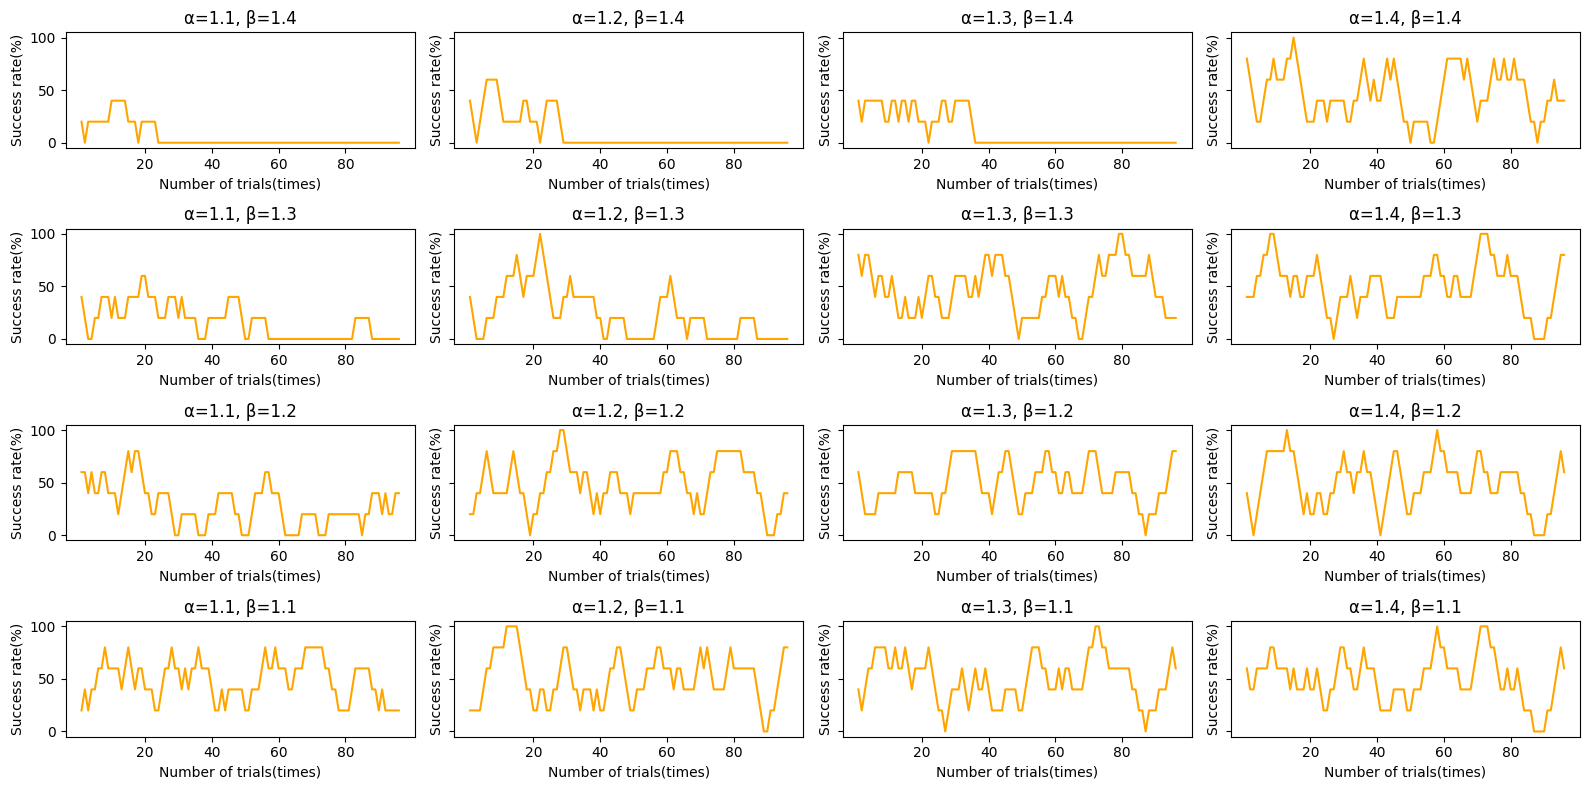

In [76]:
kendama_change.show_ajustment_from_max_graph("srate", Answer_list_divided, alpha, beta)

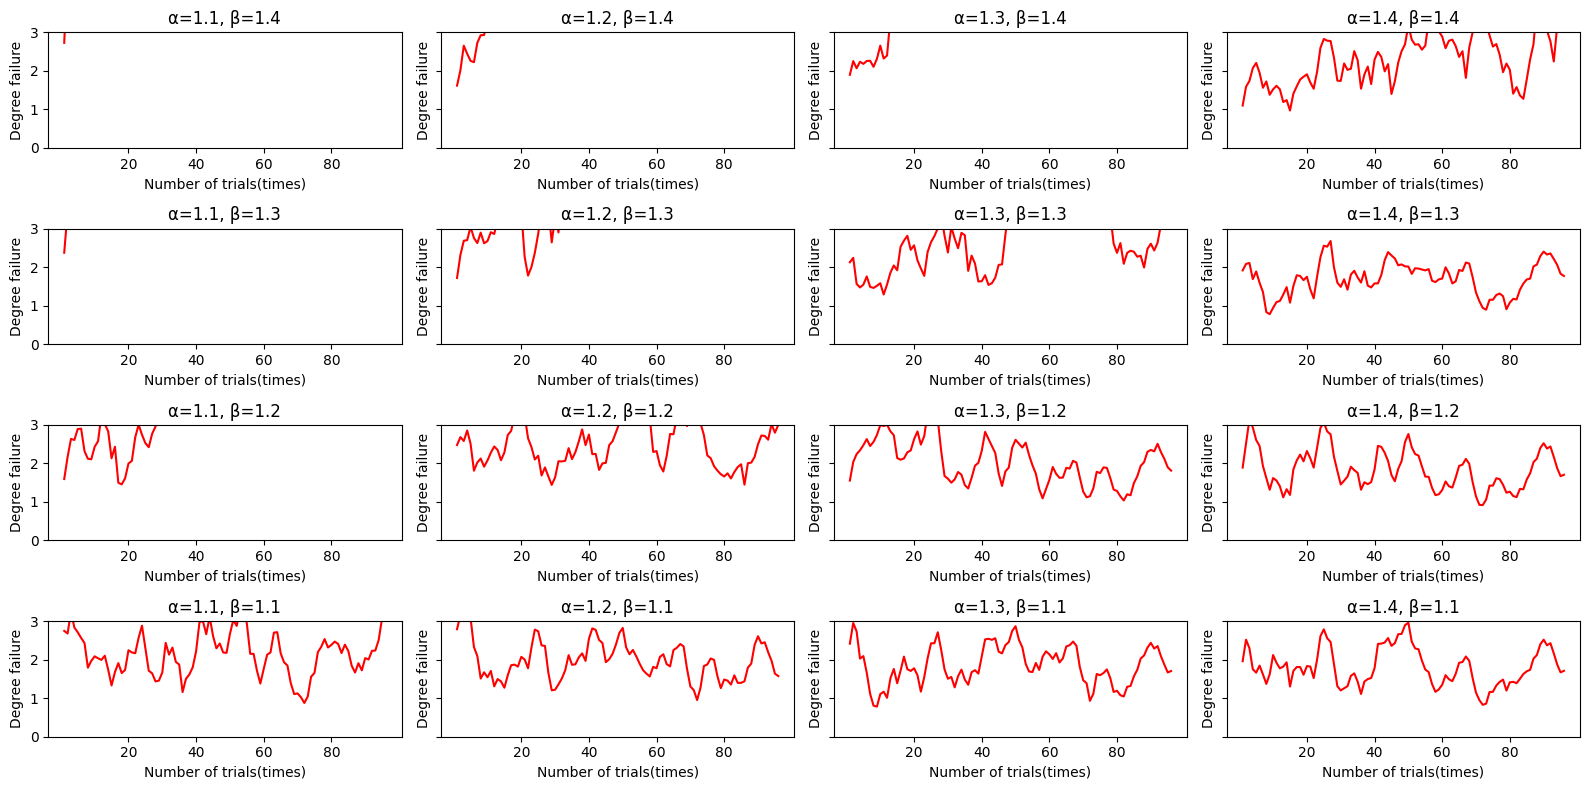

In [77]:
kendama_change.show_ajustment_from_max_graph("abs", Answer_list_divided, alpha, beta)

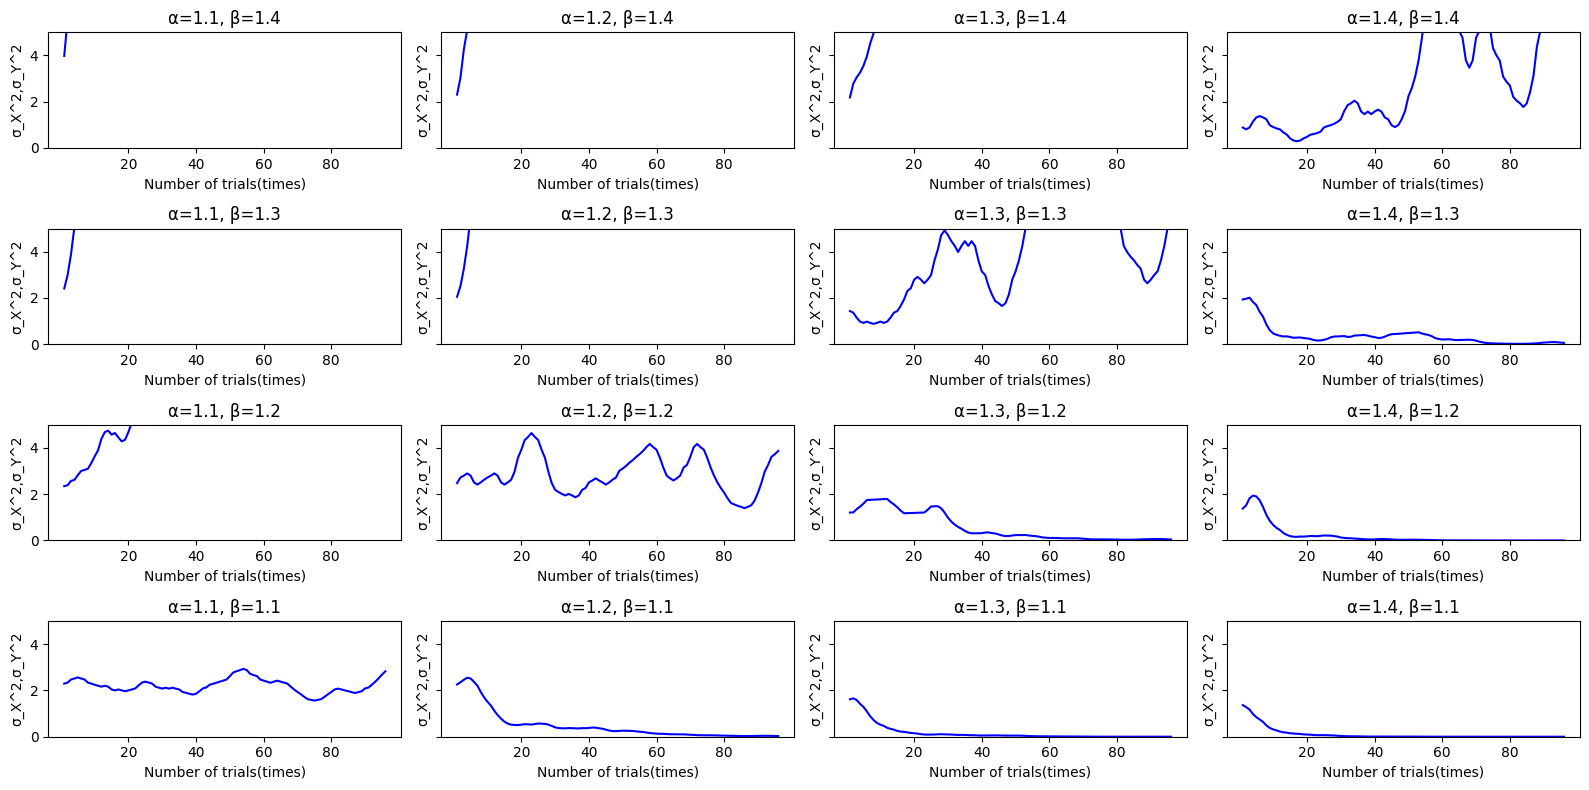

In [78]:
kendama_change.show_ajustment_from_max_graph("dispersion", Answer_list_divided, alpha, beta)

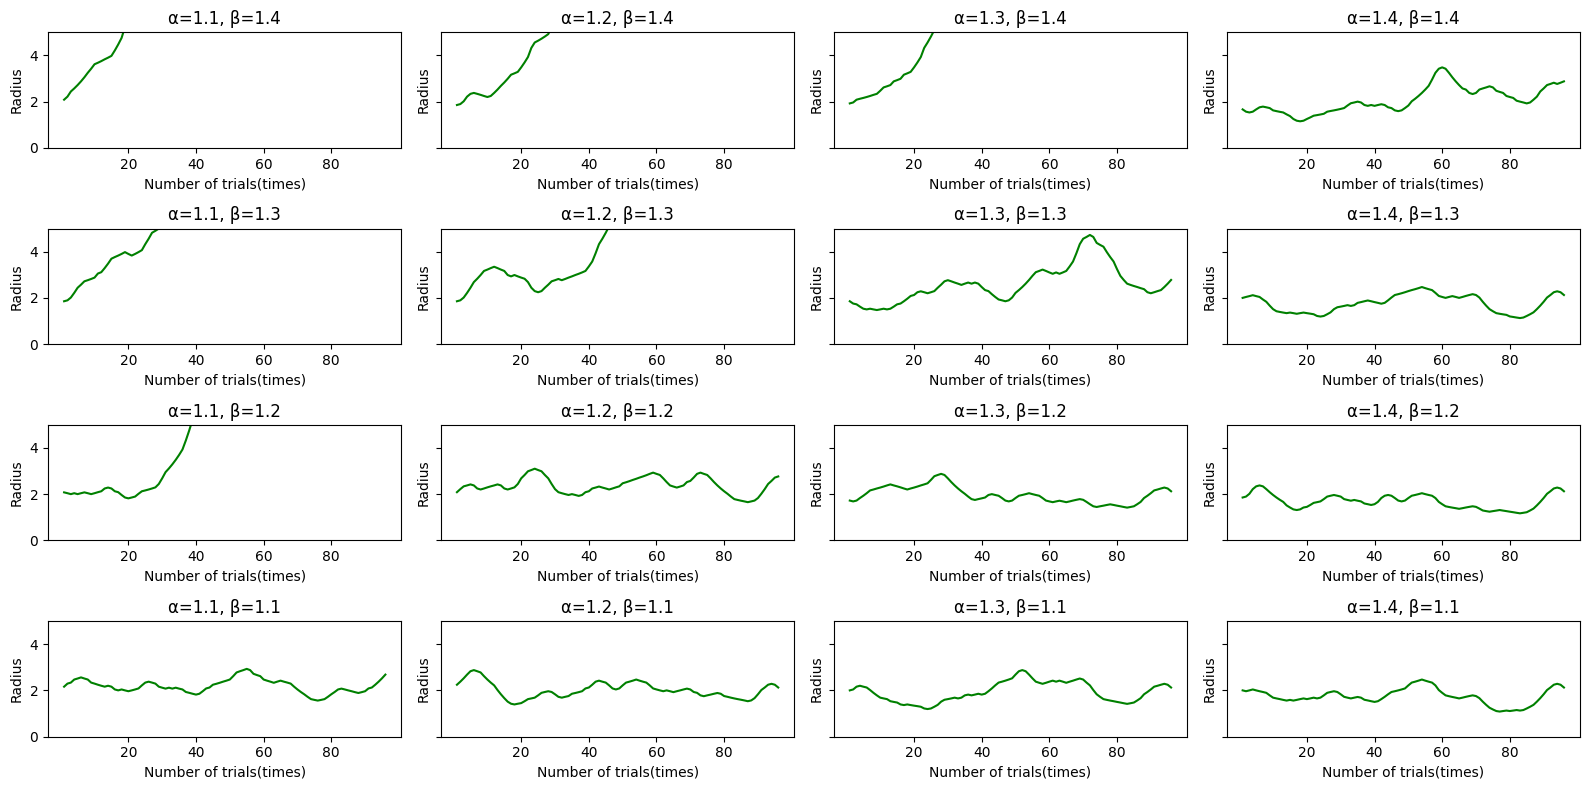

In [79]:
kendama_change.show_ajustment_from_max_graph("R", Answer_list_divided, alpha, beta)

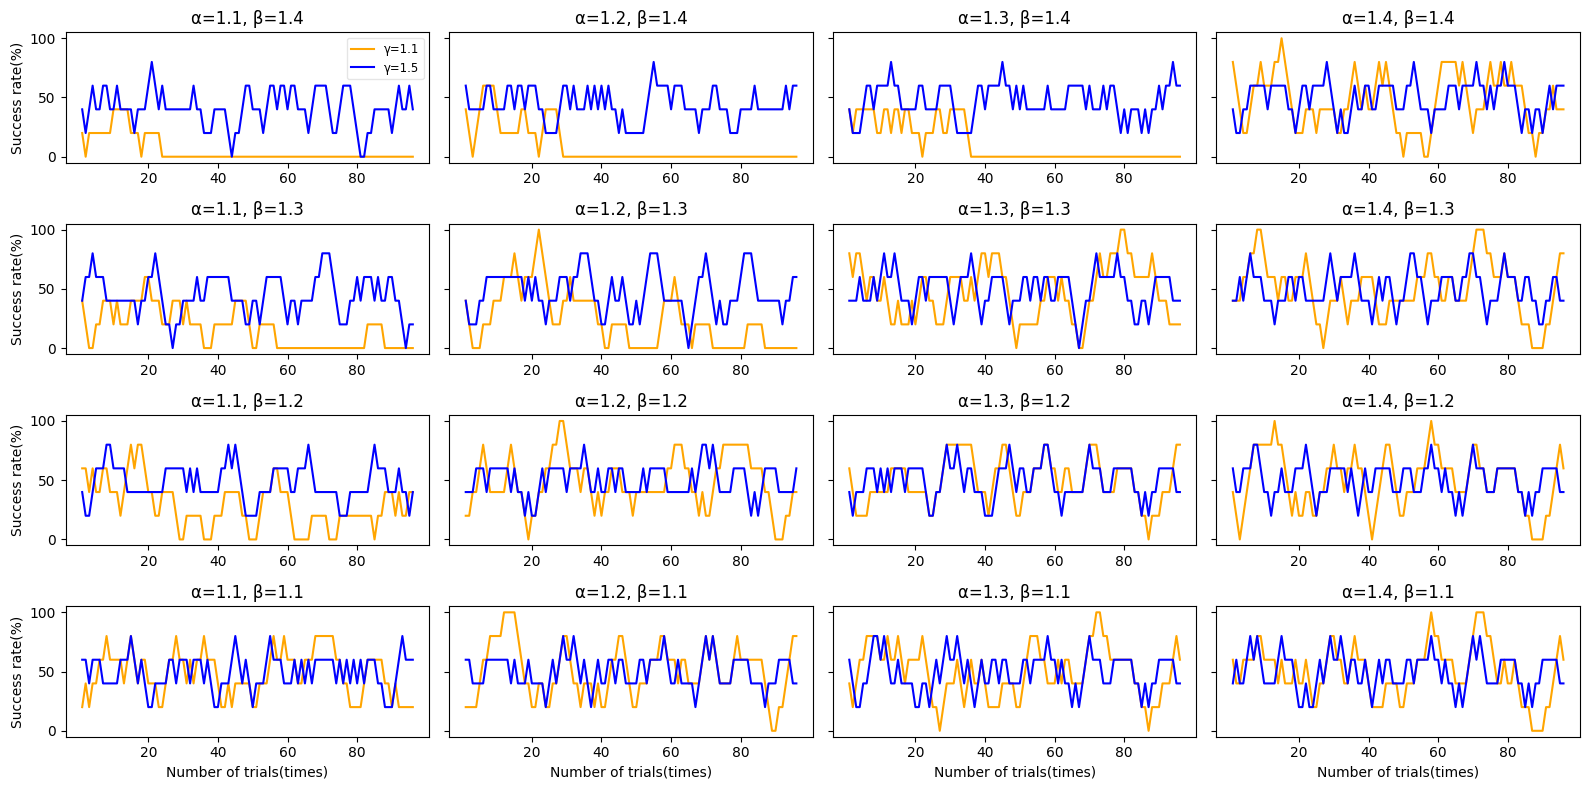

In [80]:
ganma_list = [1.1,1.5]
kendama_change.show_Comparison("srate", Answer_list_divided, alpha, beta, ganma_list) #1.5がBlue

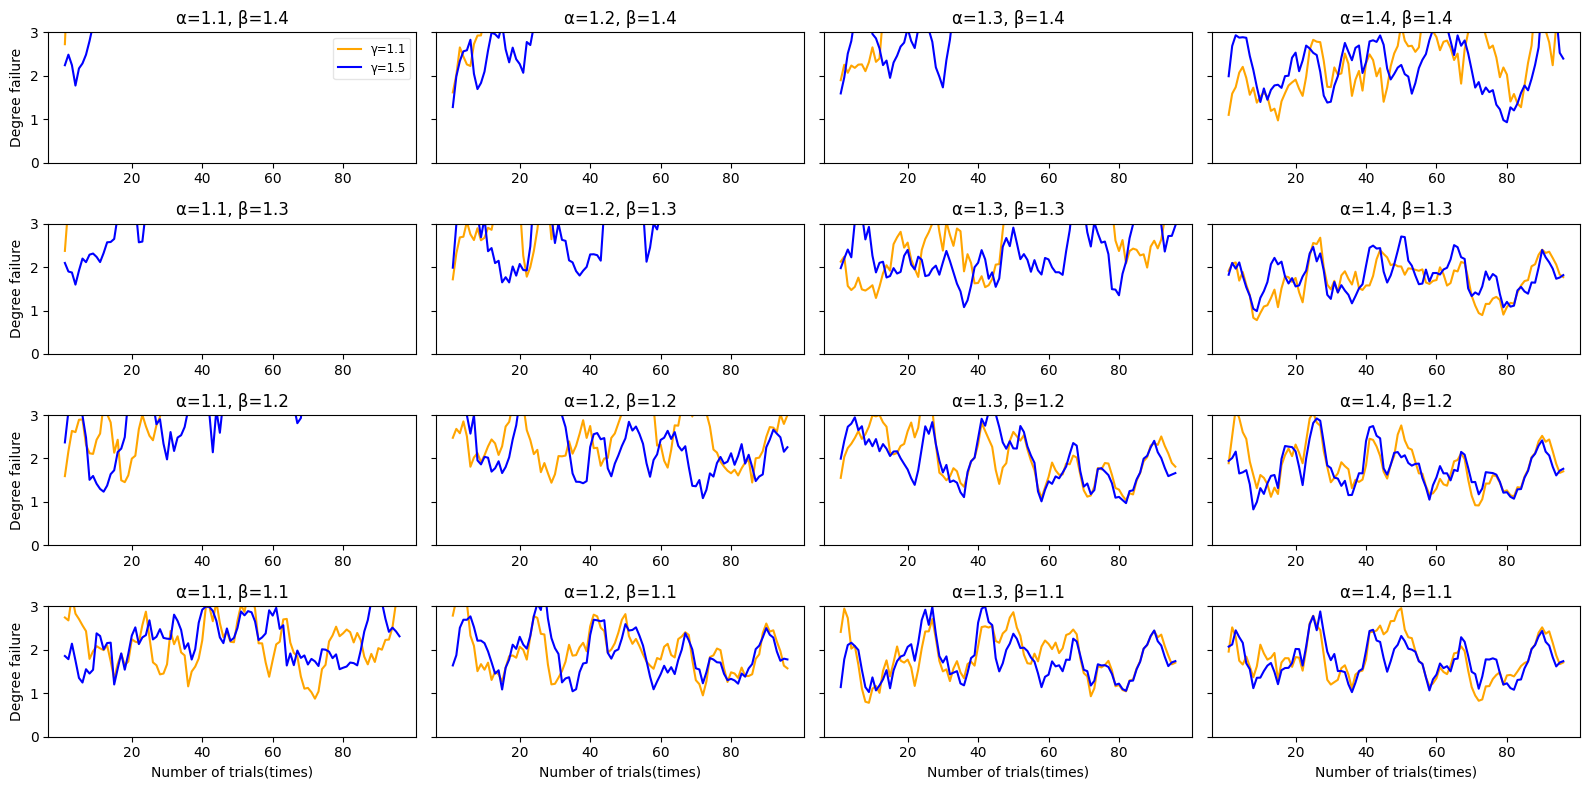

In [81]:
kendama_change.show_Comparison("abs", Answer_list_divided, alpha, beta, ganma_list)

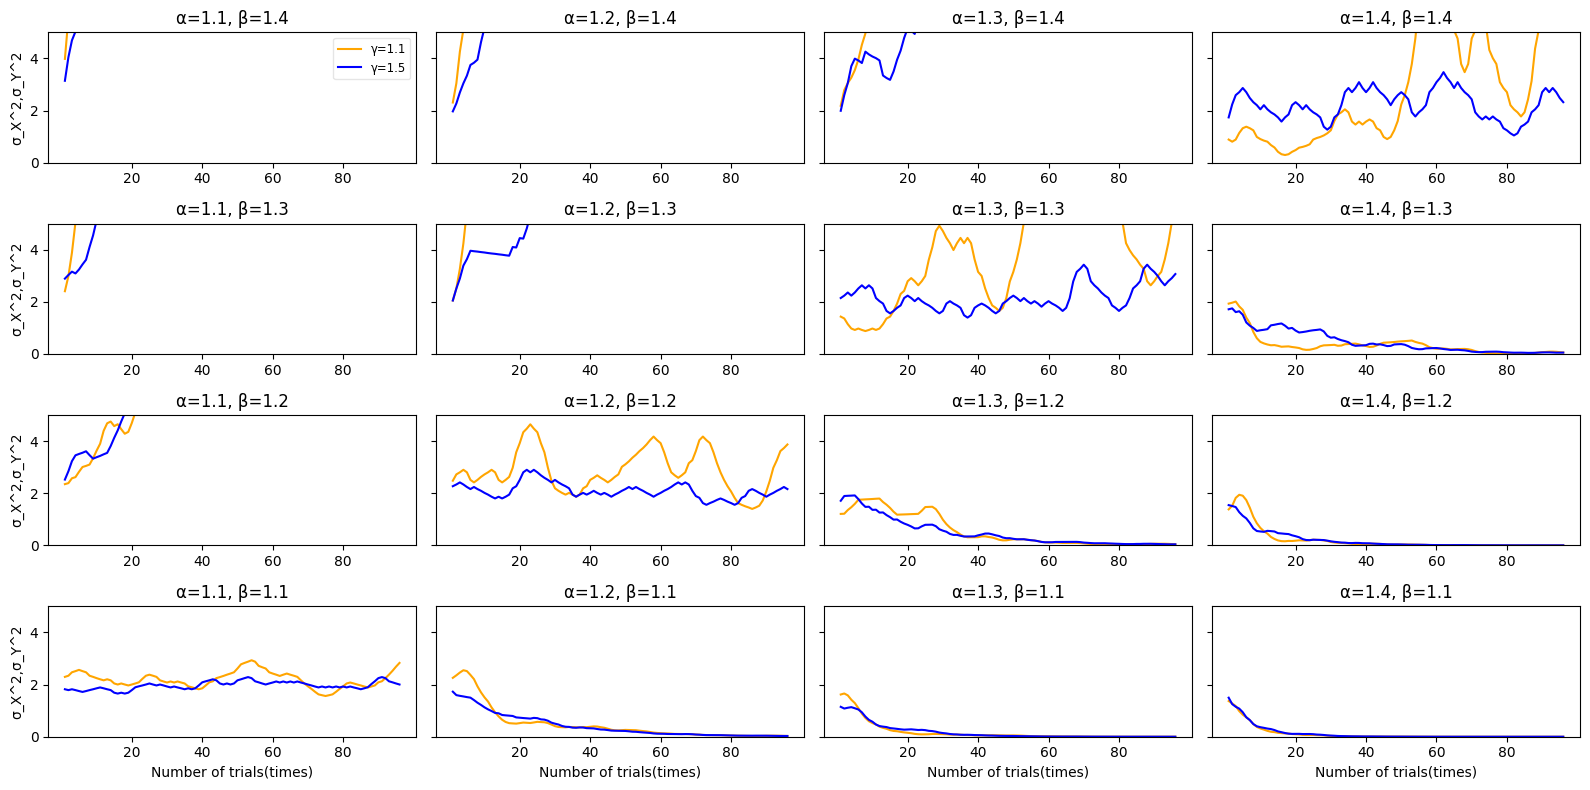

In [82]:
kendama_change.show_Comparison("dispersion", Answer_list_divided, alpha, beta, ganma_list)

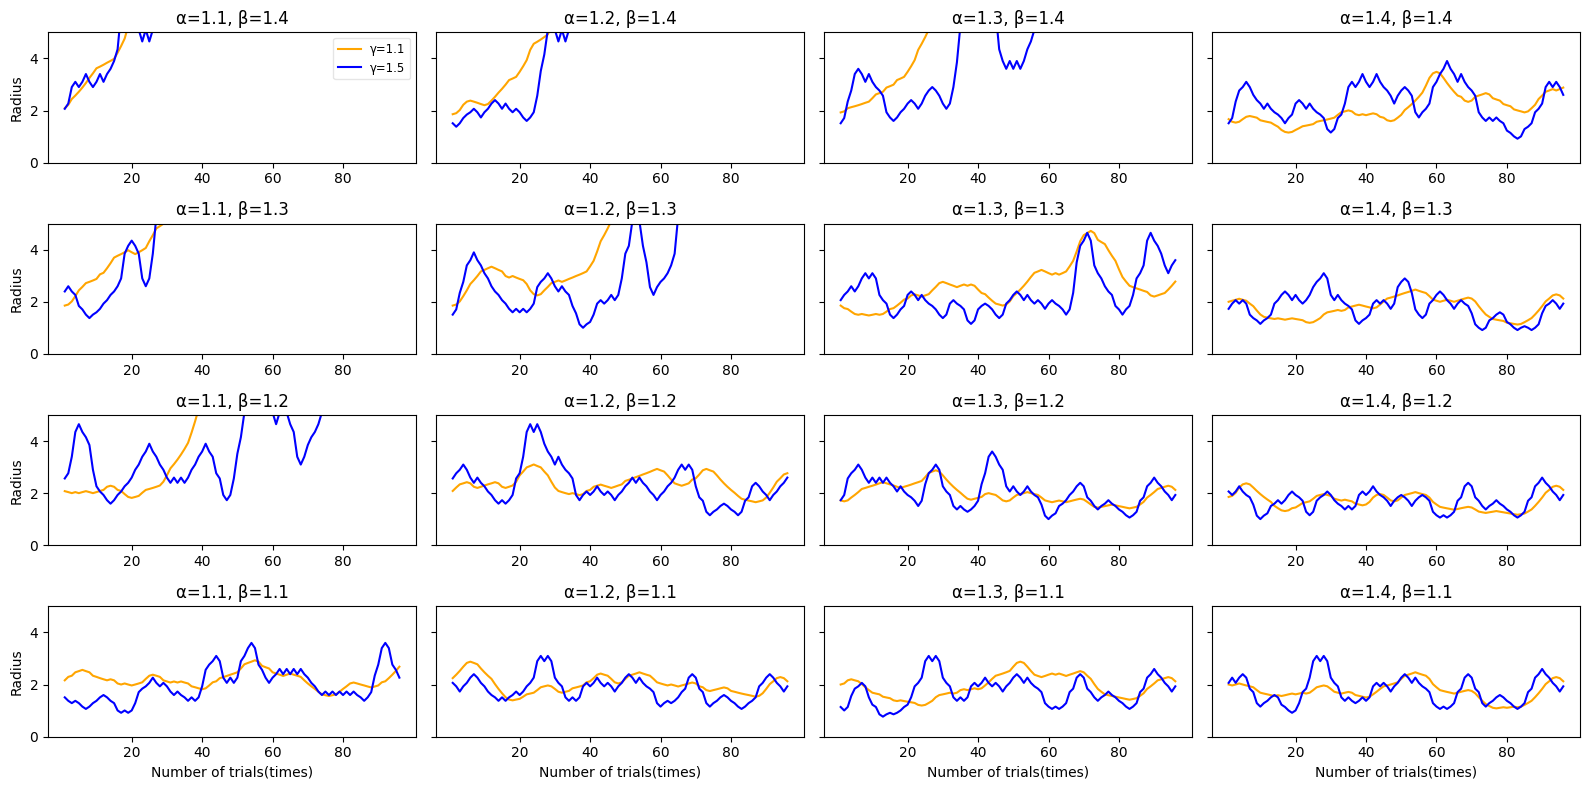

In [83]:
kendama_change.show_Comparison("R", Answer_list_divided, alpha, beta, ganma_list)

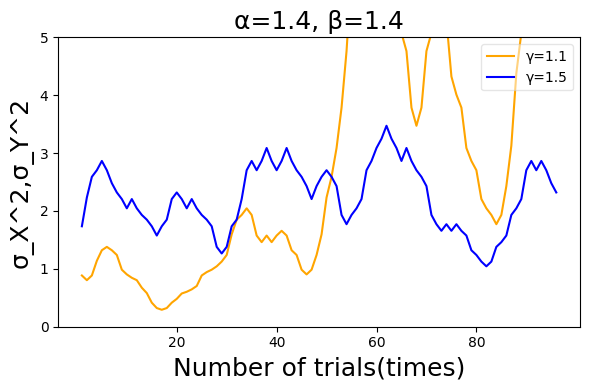

In [84]:
alpha_value = 1.4
beta_value = 1.4
kendama_change.show_excerpt("dispersion", Answer_list_divided, alpha_value, beta_value, ganma_list)